# Skin Lesion Detection - COMBINED DATASETS
## Melanoma and Skin Cancer Classification

**This notebook combines TWO datasets:**
- HAM10000: 10,015 dermoscopic images
- ISIC 2019: 2,351 images
- **TOTAL: ~12,366 images**

**Classes (9 types):**
1. actinic keratosis
2. basal cell carcinoma
3. dermatofibroma
4. melanoma
5. nevus
6. pigmented benign keratosis
7. seborrheic keratosis
8. squamous cell carcinoma
9. vascular lesion

**Estimated GPU Time:** 6-8 hours

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set project directory
import os
project_dir = '/content/drive/MyDrive/medical-ai-project/skin-lesion-detection'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/medical-ai-project/skin-lesion-detection


In [ ]:
# Install dependencies
!pip install -q torch torchvision
!pip install -q scikit-learn matplotlib seaborn
!pip install -q pillow pandas numpy
!pip install -q efficientnet-pytorch
print("✓ All dependencies installed!")

  Preparing metadata (setup.py) ... done
✓ All dependencies installed!


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Configuration

In [ ]:
# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES = 9

# Combined classes (sorted alphabetically)
CLASS_NAMES = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

print(f"Configuration:")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"\nClasses:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {i}: {name}")

Configuration:
  Image size: 224x224
  Batch size: 32
  Epochs: 30
  Learning rate: 0.0001
  Number of classes: 9

Classes:
  0: actinic keratosis
  1: basal cell carcinoma
  2: dermatofibroma
  3: melanoma
  4: nevus
  5: pigmented benign keratosis
  6: seborrheic keratosis
  7: squamous cell carcinoma
  8: vascular lesion


## Dataset Class

In [ ]:
# Custom Dataset Class for Skin Lesions
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), self.labels[idx]

print("✓ Dataset class defined")

✓ Dataset class defined


## Data Transforms

Strong augmentation is critical for skin lesion detection due to:
- Class imbalance
- Visual similarity between classes
- Limited dataset size

In [ ]:
# Data transforms with strong augmentation for skin lesions
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # Important for dermoscopy!
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Data transforms configured with strong augmentation")

✓ Data transforms configured with strong augmentation


## Load COMBINED Datasets

This cell combines:
1. HAM10000 Dataset (10,015 images with metadata)
2. ISIC 2019 Dataset (2,351 images in class folders)

Total: ~12,366 images across 9 classes

In [ ]:
# ============================================================
# COMBINED SKIN LESION DATASET LOADER
# ============================================================

print("="*70)
print("LOADING COMBINED SKIN LESION DATASETS")
print("="*70)

base_data_dir = Path('/content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data')
image_paths = []
labels = []

class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# ============================================================
# 1. Load HAM10000 Dataset
# ============================================================
print("\n📁 Loading HAM10000 Dataset...")

# HAM10000 class code mapping
ham_class_map = {
    'akiec': 'actinic keratosis',
    'bcc': 'basal cell carcinoma',
    'bkl': 'pigmented benign keratosis',
    'df': 'dermatofibroma',
    'mel': 'melanoma',
    'nv': 'nevus',
    'vasc': 'vascular lesion'
}

# Read HAM10000 metadata
ham_metadata_path = base_data_dir / 'HAM10000_metadata.csv'
if ham_metadata_path.exists():
    ham_metadata = pd.read_csv(ham_metadata_path)
    print(f"  Found metadata with {len(ham_metadata)} samples")

    # HAM10000 images are in two folders
    ham_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

    ham_loaded = 0
    for _, row in ham_metadata.iterrows():
        image_id = row['image_id']
        dx_code = row['dx']

        # Map code to full class name
        class_name = ham_class_map.get(dx_code)
        if class_name is None:
            continue

        # Search for image in both folders
        found = False
        for folder in ham_folders:
            img_path = base_data_dir / folder / f"{image_id}.jpg"
            if img_path.exists():
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
                ham_loaded += 1
                found = True
                break

        if not found:
            # Try alternative path
            for folder in ['ham10000_images_part_1', 'ham10000_images_part_2']:
                img_path = base_data_dir / folder / f"{image_id}.jpg"
                if img_path.exists():
                    image_paths.append(img_path)
                    labels.append(class_to_idx[class_name])
                    ham_loaded += 1
                    break

    print(f"  Loaded {ham_loaded:,} images from HAM10000")

    # Show distribution
    ham_labels = labels[:ham_loaded]
    print(f"\n  HAM10000 class distribution:")
    for code, full_name in ham_class_map.items():
        count = ham_labels.count(class_to_idx[full_name])
        if count > 0:
            print(f"    {code:6s} → {full_name:30s}: {count:,} images")
else:
    print("  ⚠️ HAM10000 metadata not found!")

# ============================================================
# 2. Load ISIC 2019 Dataset
# ============================================================
print("\n📁 Loading ISIC 2019 Dataset...")

isic_base = base_data_dir / 'isic2019' / 'Skin cancer ISIC The International Skin Imaging Collaboration'

isic_loaded = 0
if isic_base.exists():
    # Load from Train folder
    train_path = isic_base / 'Train'
    if train_path.exists():
        for class_folder in train_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name

                # Check if this class is in our combined list
                if class_name in class_to_idx:
                    class_images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
                    image_paths.extend(class_images)
                    labels.extend([class_to_idx[class_name]] * len(class_images))
                    isic_loaded += len(class_images)
                    print(f"    Train/{class_name:30s}: {len(class_images)} images")

    # Optionally load Test folder (small, but adds variety)
    test_path = isic_base / 'Test'
    if test_path.exists():
        for class_folder in test_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                if class_name in class_to_idx:
                    class_images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
                    image_paths.extend(class_images)
                    labels.extend([class_to_idx[class_name]] * len(class_images))
                    isic_loaded += len(class_images)

    print(f"\n  Loaded {isic_loaded:,} images from ISIC 2019")
else:
    print("  ⚠️ ISIC 2019 dataset not found!")

# ============================================================
# Summary
# ============================================================
print("\n" + "="*70)
print("COMBINED DATASET SUMMARY")
print("="*70)
print(f"Total images loaded: {len(image_paths):,}")
print(f"  From HAM10000: {ham_loaded:,}")
print(f"  From ISIC 2019: {isic_loaded:,}")

print(f"\nCombined class distribution:")
class_counts = np.bincount(labels)
for i, class_name in enumerate(CLASS_NAMES):
    if class_counts[i] > 0:
        percentage = class_counts[i] / len(labels) * 100
        print(f"  {i}. {class_name:30s}: {class_counts[i]:,} images ({percentage:.1f}%)")

# ============================================================
# Split into train and validation sets
# ============================================================
print("\n" + "="*70)
print("SPLITTING DATA (Stratified)")
print("="*70)

X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# Create datasets and loaders
train_dataset = SkinLesionDataset(X_train, y_train, transform=train_transform)
val_dataset = SkinLesionDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✓ Combined dataset loaded successfully!")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print("="*70)

LOADING COMBINED SKIN LESION DATASETS

📁 Loading HAM10000 Dataset...
  Found metadata with 10015 samples
  Loaded 10,015 images from HAM10000

  HAM10000 class distribution:
    akiec  → actinic keratosis             : 327 images
    bcc    → basal cell carcinoma          : 514 images
    bkl    → pigmented benign keratosis    : 1,099 images
    df     → dermatofibroma                : 115 images
    mel    → melanoma                      : 1,113 images
    nv     → nevus                         : 6,705 images
    vasc   → vascular lesion               : 142 images

📁 Loading ISIC 2019 Dataset...
  ⚠️ ISIC 2019 dataset not found!

COMBINED DATASET SUMMARY
Total images loaded: 10,015
  From HAM10000: 10,015
  From ISIC 2019: 0

Combined class distribution:
  0. actinic keratosis             : 327 images (3.3%)
  1. basal cell carcinoma          : 514 images (5.1%)
  2. dermatofibroma                : 115 images (1.1%)
  3. melanoma                      : 1,113 images (11.1%)
  4. nevus 

In [ ]:
  # Check what path the notebook is looking for
print("Checking ISIC 2019 path in notebook...")
print("="*70)

  # What we know exists
actual_isic = base_data_dir / 'Skin cancer ISIC The International Skin Imaging Collaboration' / 'Train'
print(f"\nActual ISIC location (verified exists):")
print(f"  {actual_isic}")
print(f"  Exists: {actual_isic.exists()}")

  # Common paths the notebook might be checking
possible_paths = [
      base_data_dir / 'isic2019' / 'Skin cancer ISIC The International Skin Imaging Collaboration' / 'Train',
      base_data_dir / 'ISIC2019' / 'Train',
      base_data_dir / 'isic' / 'Train',
      base_data_dir / 'Skin cancer ISIC The International Skin Imaging Collaboration' / 'Train',
  ]

print("\nPaths the notebook might be checking:")
for i, path in enumerate(possible_paths, 1):
      print(f"  {i}. {path}")
      print(f"     Exists: {path.exists()}")



Checking ISIC 2019 path in notebook...

Actual ISIC location (verified exists):
  /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train
  Exists: True

Paths the notebook might be checking:
  1. /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/isic2019/Skin cancer ISIC The International Skin Imaging Collaboration/Train
     Exists: False
  2. /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/ISIC2019/Train
     Exists: False
  3. /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/isic/Train
     Exists: False
  4. /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train
     Exists: True


In [ ]:
from pathlib import Path

  # What the notebook is currently configured to use
print("Current notebook paths:")
print(f"base_data_dir = {base_data_dir}")
print(f"ham10000_path = {ham10000_path if 'ham10000_path' in dir() else 'not defined'}")
print(f"isic_path = {isic_path if 'isic_path' in dir() else 'not defined'}")

print("\n" + "="*70)
print("ACTUAL DATA LOCATION:")
print("="*70)

  # Where your data actually is
actual_base = Path('/content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data')
print(f"\nBase directory exists: {actual_base.exists()}")

print("\nHAM10000 files:")
print(f"  ✓ {actual_base / 'HAM10000_metadata.csv'} exists: {(actual_base / 'HAM10000_metadata.csv').exists()}")
print(f"  ✓ {actual_base / 'HAM10000_images_part_1'} exists: {(actual_base / 'HAM10000_images_part_1').exists()}")

print("\nISIC 2019 files:")
isic_train = actual_base / 'Skin cancer ISIC The International Skin Imaging Collaboration' / 'Train'
print(f"  ✓ {isic_train} exists: {isic_train.exists()}")



Current notebook paths:
base_data_dir = data
ham10000_path = not defined
isic_path = not defined

ACTUAL DATA LOCATION:

Base directory exists: True

HAM10000 files:
  ✓ /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/HAM10000_metadata.csv exists: True
  ✓ /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/HAM10000_images_part_1 exists: True

ISIC 2019 files:
  ✓ /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train exists: True


In [ ]:
import os
import json
from getpass import getpass

  # Create .kaggle directory
!mkdir -p ~/.kaggle

print("=" * 60)
print("KAGGLE API SETUP")
print("=" * 60)
print("\nGet your credentials from: https://www.kaggle.com/settings/account")
print("(Click 'Create New API Token' to download kaggle.json)\n")

  # Enter your Kaggle credentials securely
kaggle_username = input("Kaggle Username: ")
kaggle_key = getpass("Kaggle API Key (hidden): ")

  # Create kaggle.json
kaggle_credentials = {
      "username": kaggle_username,
      "key": kaggle_key
  }

with open('/root/.kaggle/kaggle.json', 'w') as f:
      json.dump(kaggle_credentials, f)

  # Set permissions
!chmod 600 ~/.kaggle/kaggle.json

print("\n✓ Kaggle API configured successfully!")
print("\nTesting connection...")
!kaggle datasets list --max-size 100


KAGGLE API SETUP

Get your credentials from: https://www.kaggle.com/settings/account
(Click 'Create New API Token' to download kaggle.json)

Kaggle Username: kkanyuchi
Kaggle API Key (hidden): ··········

✓ Kaggle API configured successfully!

Testing connection...
ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
mczielinski/bitcoin-historical-data                           Bitcoin Historical Data                              103795956  2025-12-31 00:09:19.197000         250105       3949  1.0              
madhavmalhotra/unb-cic-iot-dataset                            UNB CIC IOT 2023 Dataset                            2978571232  2023-09-06 14:

In [ ]:
import os
import shutil
from pathlib import Path

  # Navigate to data directory
os.chdir('/content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data')

print("Step 1: Removing old ISIC download...")
print("=" * 60)

  # Remove the incorrect download
old_folder = "Skin cancer ISIC The International Skin Imaging Collaboration"
if os.path.exists(old_folder):
      shutil.rmtree(old_folder)
      print(f"✓ Removed: {old_folder}")
else:
      print("Folder not found (already removed)")

print("\n\nStep 2: Downloading correct ISIC 2019 dataset...")
print("=" * 60)
print("This will take ~15-20 minutes depending on connection speed")
print("Dataset: skin-cancer9-classesisic (with proper folder structure)\n")

  # Download the correct ISIC 2019 dataset with folder structure
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

print("\n\nStep 3: Extracting dataset...")
print("=" * 60)

!unzip -q skin-cancer9-classesisic.zip

print("✓ Extraction complete!")

print("\n\nStep 4: Cleaning up...")
print("=" * 60)

!rm skin-cancer9-classesisic.zip

print("✓ Zip file removed")
print("\n🎉 ISIC 2019 dataset re-download complete!")



Step 1: Removing old ISIC download...
Folder not found (already removed)


Step 2: Downloading correct ISIC 2019 dataset...
This will take ~15-20 minutes depending on connection speed
Dataset: skin-cancer9-classesisic (with proper folder structure)

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
100% 785M/786M [00:01<00:00, 448MB/s]
100% 786M/786M [00:01<00:00, 439MB/s]


Step 3: Extracting dataset...
✓ Extraction complete!


Step 4: Cleaning up...
✓ Zip file removed

🎉 ISIC 2019 dataset re-download complete!


In [ ]:
from pathlib import Path

base_dir = Path('/content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data')

print("=" * 70)
print("VERIFYING ISIC 2019 DATASET STRUCTURE")
print("=" * 70)

  # Look for the ISIC folder
isic_folders = list(base_dir.glob('*ISIC*')) + list(base_dir.glob('*skin*'))
print(f"\nFound {len(isic_folders)} ISIC-related folder(s):")
for folder in isic_folders:
      print(f"  📁 {folder.name}")

  # Try to find the Train directory
possible_paths = [
      base_dir / 'Skin cancer ISIC The International Skin Imaging Collaboration' / 'Train',
      base_dir / 'Train',
      base_dir / 'train',
  ]

train_dir = None
for path in possible_paths:
      if path.exists() and path.is_dir():
          train_dir = path
          print(f"\n✓ Found Train directory: {train_dir}")
          break

if not train_dir:
      # List all directories to help find it
      print("\n⚠️ Could not find Train directory. Here's what's in data/:")
      for item in sorted(base_dir.iterdir()):
          if item.is_dir():
              print(f"  📁 {item.name}")
              # Check one level deeper
              for subitem in sorted(item.iterdir())[:5]:
                  print(f"      📁 {subitem.name}")
else:
      # Verify class folders exist
      print("\n" + "=" * 70)
      print("ISIC 2019 CLASS DISTRIBUTION")
      print("=" * 70)

      total = 0
      class_counts = {}

      for class_folder in sorted(train_dir.iterdir()):
          if class_folder.is_dir():
              count = len(list(class_folder.glob('*.jpg'))) + len(list(class_folder.glob('*.png')))
              class_counts[class_folder.name] = count
              total += count
              print(f"  ✓ {class_folder.name:.<40} {count:>5} images")

      print("=" * 70)
      print(f"TOTAL ISIC 2019 IMAGES: {total:,}")
      print("=" * 70)

      # Check if we have the expected 9 classes
      expected_classes = [
          'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
          'melanoma', 'nevus', 'pigmented benign keratosis',
          'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'
      ]

      found_classes = set(class_counts.keys())
      expected_set = set(expected_classes)

      if found_classes == expected_set:
          print("\n✅ Perfect! All 9 expected classes found!")
      else:
          missing = expected_set - found_classes
          extra = found_classes - expected_set
          if missing:
              print(f"\n⚠️ Missing classes: {missing}")
          if extra:
              print(f"\n⚠️ Extra classes: {extra}")



VERIFYING ISIC 2019 DATASET STRUCTURE

Found 1 ISIC-related folder(s):
  📁 Skin cancer ISIC The International Skin Imaging Collaboration

✓ Found Train directory: /content/drive/MyDrive/medical-ai-project/skin-lesion-detection/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train

ISIC 2019 CLASS DISTRIBUTION
  ✓ actinic keratosis.......................   114 images
  ✓ basal cell carcinoma....................   376 images
  ✓ dermatofibroma..........................    95 images
  ✓ melanoma................................   438 images
  ✓ nevus...................................   357 images
  ✓ pigmented benign keratosis..............   462 images
  ✓ seborrheic keratosis....................    77 images
  ✓ squamous cell carcinoma.................   181 images
  ✓ vascular lesion.........................   139 images
TOTAL ISIC 2019 IMAGES: 2,239

✅ Perfect! All 9 expected classes found!


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

print("="*70)
print("RELOADING HAM10000 DATASET")
print("="*70)

metadata_path = base_data_dir / 'HAM10000_metadata.csv'
ham10000_df = pd.read_csv(metadata_path)

print(f"✓ Loaded metadata with {len(ham10000_df)} samples")

  # Map HAM10000 codes to class indices
ham10000_class_mapping = {
      'akiec': 0,  # actinic keratosis
      'bcc': 1,    # basal cell carcinoma
      'df': 2,     # dermatofibroma
      'mel': 3,    # melanoma
      'nv': 4,     # nevus
      'bkl': 5,    # pigmented benign keratosis
      'vasc': 8    # vascular lesion
  }

ham10000_images = []
ham10000_labels = []

image_dirs = [
      base_data_dir / 'HAM10000_images_part_1',
      base_data_dir / 'HAM10000_images_part_2'
  ]

for _, row in ham10000_df.iterrows():
      image_id = row['image_id']
      dx_code = row['dx']

      if dx_code in ham10000_class_mapping:
          # Find the image file
          for img_dir in image_dirs:
              img_path = img_dir / f"{image_id}.jpg"
              if img_path.exists():
                  ham10000_images.append(str(img_path))
                  ham10000_labels.append(ham10000_class_mapping[dx_code])
                  break

print(f"✓ Loaded {len(ham10000_images):,} images from HAM10000")

  # Now combine with ISIC 2019
print("\n" + "="*70)
print("COMBINING HAM10000 + ISIC 2019")
print("="*70)

all_images = ham10000_images + isic_images
all_labels = ham10000_labels + isic_labels

print(f"\nTotal combined images: {len(all_images):,}")
print(f"  From HAM10000: {len(ham10000_images):,}")
print(f"  From ISIC 2019: {len(isic_images):,}")

  # Show combined class distribution
print("\n" + "="*70)
print("COMBINED CLASS DISTRIBUTION")
print("="*70)

CLASS_NAMES = [
      'actinic keratosis',
      'basal cell carcinoma',
      'dermatofibroma',
      'melanoma',
      'nevus',
      'pigmented benign keratosis',
      'seborrheic keratosis',
      'squamous cell carcinoma',
      'vascular lesion'
  ]

labels_array = np.array(all_labels)
class_counts = np.bincount(labels_array)

for i in range(len(CLASS_NAMES)):
     if i < len(class_counts) and class_counts[i] > 0:
          percentage = class_counts[i] / len(labels_array) * 100
          print(f"  {i}. {CLASS_NAMES[i]:30s}: {class_counts[i]:,} images ({percentage:.1f}%)")

print("\n" + "="*70)
print("✅ SUCCESS! FULL COMBINED DATASET READY!")
print("="*70)
print(f"\n🎉 Ready to train on {len(all_images):,} images across 9 classes!")



RELOADING HAM10000 DATASET
✓ Loaded metadata with 10015 samples
✓ Loaded 10,015 images from HAM10000

COMBINING HAM10000 + ISIC 2019

Total combined images: 12,254
  From HAM10000: 10,015
  From ISIC 2019: 2,239

COMBINED CLASS DISTRIBUTION
  0. actinic keratosis             : 441 images (3.6%)
  1. basal cell carcinoma          : 890 images (7.3%)
  2. dermatofibroma                : 210 images (1.7%)
  3. melanoma                      : 1,551 images (12.7%)
  4. nevus                         : 7,062 images (57.6%)
  5. pigmented benign keratosis    : 1,561 images (12.7%)
  6. seborrheic keratosis          : 77 images (0.6%)
  7. squamous cell carcinoma       : 181 images (1.5%)
  8. vascular lesion               : 281 images (2.3%)

✅ SUCCESS! FULL COMBINED DATASET READY!

🎉 Ready to train on 12,254 images across 9 classes!


## Model Architecture

Using ResNet50 with ImageNet pre-trained weights

In [ ]:
# Load pre-trained ResNet50
print("Loading ResNet50 with ImageNet weights...")
model = models.resnet50(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 9 classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)
print(f"✓ Model loaded on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading ResNet50 with ImageNet weights...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


✓ Model loaded on cuda
Total parameters: 24,562,761
Trainable parameters: 1,054,729


## Training Setup with Class Balancing

**CRITICAL:** Skin lesion data is highly imbalanced (nevus has ~7000 samples, some classes have <200)

We use weighted loss to handle this.

In [ ]:

import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

print("="*70)
print("CALCULATING CLASS WEIGHTS (WITH ALL 9 CLASSES)")
print("="*70)

  # Calculate class counts for all 9 classes
y_train_array = np.array(y_train)
class_counts = np.bincount(y_train_array, minlength=9)

print("\nClass distribution in training set:")
print("="*70)

  # Calculate balanced class weights
class_weights_array = compute_class_weight(
      class_weight='balanced',
      classes=np.arange(9),
      y=y_train_array
  )

  # Convert to tensor
class_weights = torch.FloatTensor(class_weights_array).to(device)

  # Display distribution and weights
total_with_samples = 0
for i, name in enumerate(CLASS_NAMES):
      if class_counts[i] > 0:
          total_with_samples += 1
          print(f"  {name:30s}: {class_counts[i]:,} samples (weight: {class_weights[i]:.4f})")
      else:
          print(f"  {name:30s}: 0 samples ⚠️")

print("="*70)
print(f"✓ All {total_with_samples}/9 classes have samples!")
print("="*70)

  # Setup loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("\n✅ Training setup complete with proper class balancing for all 9 classes!")



CALCULATING CLASS WEIGHTS (WITH ALL 9 CLASSES)

Class distribution in training set:
  actinic keratosis             : 353 samples (weight: 3.0856)
  basal cell carcinoma          : 712 samples (weight: 1.5298)
  dermatofibroma                : 168 samples (weight: 6.4835)
  melanoma                      : 1,241 samples (weight: 0.8777)
  nevus                         : 5,649 samples (weight: 0.1928)
  pigmented benign keratosis    : 1,249 samples (weight: 0.8721)
  seborrheic keratosis          : 61 samples (weight: 17.8561)
  squamous cell carcinoma       : 145 samples (weight: 7.5119)
  vascular lesion               : 225 samples (weight: 4.8410)
✓ All 9/9 classes have samples!

✅ Training setup complete with proper class balancing for all 9 classes!


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

print("="*70)
print("CREATING TRAIN/VALIDATION SPLIT")
print("="*70)

  # Use the combined dataset we just created
X = all_images  # 12,254 images
y = all_labels  # 12,254 labels

print(f"\nTotal dataset: {len(X):,} images")
print(f"Labels: {len(y):,}")

  # Verify all 9 classes are present
unique_classes = np.unique(y)
print(f"\nClasses in full dataset: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")

  # Check class distribution BEFORE split
class_counts_full = np.bincount(np.array(y), minlength=9)
print("\nFull dataset class distribution:")
for i in range(9):
      if class_counts_full[i] > 0:
          print(f"  {i}. {CLASS_NAMES[i]:30s}: {class_counts_full[i]} images")

  # Stratified split to preserve class distribution
  # 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
      X, y,
      test_size=0.2,
      stratify=y,
      random_state=42
  )

print(f"\n✓ Split complete:")
print(f"  Training: {len(X_train):,} samples")
print(f"  Validation: {len(X_val):,} samples")

  # Verify all classes present in training
train_classes = np.unique(y_train)
print(f"\n✓ Classes in training set: {len(train_classes)}/9")

if len(train_classes) < 9:
      print("⚠️ WARNING: Not all classes in training set!")
else:
      print("✅ All 9 classes present in training set!")



CREATING TRAIN/VALIDATION SPLIT

Total dataset: 12,254 images
Labels: 12,254

Classes in full dataset: [0 1 2 3 4 5 6 7 8]
Number of classes: 9

Full dataset class distribution:
  0. actinic keratosis             : 441 images
  1. basal cell carcinoma          : 890 images
  2. dermatofibroma                : 210 images
  3. melanoma                      : 1551 images
  4. nevus                         : 7062 images
  5. pigmented benign keratosis    : 1561 images
  6. seborrheic keratosis          : 77 images
  7. squamous cell carcinoma       : 181 images
  8. vascular lesion               : 281 images

✓ Split complete:
  Training: 9,803 samples
  Validation: 2,451 samples

✓ Classes in training set: 9/9
✅ All 9 classes present in training set!


## Training Functions

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        pbar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc.item()


def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    return epoch_loss, epoch_acc.item()

print("✓ Training functions defined")

✓ Training functions defined


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

print("="*70)
print("CREATING DATASETS AND DATALOADERS")
print("="*70)

  # Define transforms
train_transform = transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(20),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

val_transform = transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  # Create dataset instances
train_dataset = SkinLesionDataset(X_train, y_train, transform=train_transform)
val_dataset = SkinLesionDataset(X_val, y_val, transform=val_transform)

print(f"✓ Training dataset: {len(train_dataset):,} samples")
print(f"✓ Validation dataset: {len(val_dataset):,} samples")

  # Create dataloaders
BATCH_SIZE = 32  # Adjust if needed

train_loader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=2,
      pin_memory=True
  )

val_loader = DataLoader(
      val_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False,
      num_workers=2,
      pin_memory=True
  )

print(f"\n✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")

print("\n✅ DataLoaders ready for training!")
print("="*70)



CREATING DATASETS AND DATALOADERS
✓ Training dataset: 9,803 samples
✓ Validation dataset: 2,451 samples

✓ Training batches: 307
✓ Validation batches: 77

✅ DataLoaders ready for training!


## Training Loop

**This will take 6-8 hours on a T4 GPU**

The model will save automatically whenever validation accuracy improves.

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_acc = 0.0
best_model_path = './models/best_skin_lesion_COMBINED_model.pth'
os.makedirs('./models', exist_ok=True)

print("="*70)
print(f"STARTING TRAINING - {NUM_EPOCHS} EPOCHS")
print("="*70)
print(f"Training on {len(train_loader.dataset):,} images")
print(f"Validating on {len(val_loader.dataset):,} images")
print(f"Model will save to: {best_model_path}")
print("="*70)

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'\n📊 Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    scheduler.step(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'✓ Best model saved with accuracy: {best_acc:.4f}')

print(f"\n🎉 Training complete! Best validation accuracy: {best_acc:.4f}")
print("="*70)

STARTING TRAINING - 30 EPOCHS
Training on 9,803 images
Validating on 2,451 images
Model will save to: ./models/best_skin_lesion_COMBINED_model.pth

📊 Epoch 1/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [12:26<00:00,  9.70s/it]


Train Loss: 1.9990 | Train Acc: 0.2550
Val Loss: 1.6131 | Val Acc: 0.4227
✓ Best model saved with accuracy: 0.4227

📊 Epoch 2/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.80it/s]


Train Loss: 1.6978 | Train Acc: 0.3815
Val Loss: 1.4960 | Val Acc: 0.4774
✓ Best model saved with accuracy: 0.4774

📊 Epoch 3/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.88it/s]


Train Loss: 1.5765 | Train Acc: 0.4054
Val Loss: 1.4315 | Val Acc: 0.4953
✓ Best model saved with accuracy: 0.4953

📊 Epoch 4/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 1.5325 | Train Acc: 0.4265
Val Loss: 1.4286 | Val Acc: 0.4737

📊 Epoch 5/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.95it/s]


Train Loss: 1.5241 | Train Acc: 0.4366
Val Loss: 1.3778 | Val Acc: 0.5075
✓ Best model saved with accuracy: 0.5075

📊 Epoch 6/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 1.4505 | Train Acc: 0.4553
Val Loss: 1.3636 | Val Acc: 0.5222
✓ Best model saved with accuracy: 0.5222

📊 Epoch 7/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.81it/s]


Train Loss: 1.4538 | Train Acc: 0.4663
Val Loss: 1.3078 | Val Acc: 0.5728
✓ Best model saved with accuracy: 0.5728

📊 Epoch 8/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.92it/s]


Train Loss: 1.4262 | Train Acc: 0.4862
Val Loss: 1.3101 | Val Acc: 0.5585

📊 Epoch 9/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.85it/s]


Train Loss: 1.4503 | Train Acc: 0.4742
Val Loss: 1.3142 | Val Acc: 0.5390

📊 Epoch 10/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.80it/s]


Train Loss: 1.4143 | Train Acc: 0.4890
Val Loss: 1.3010 | Val Acc: 0.5687

📊 Epoch 11/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.82it/s]


Train Loss: 1.4293 | Train Acc: 0.5067
Val Loss: 1.3008 | Val Acc: 0.5826
✓ Best model saved with accuracy: 0.5826

📊 Epoch 12/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.80it/s]


Train Loss: 1.3952 | Train Acc: 0.5127
Val Loss: 1.2941 | Val Acc: 0.5422

📊 Epoch 13/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.77it/s]


Train Loss: 1.3734 | Train Acc: 0.5199
Val Loss: 1.2794 | Val Acc: 0.5700

📊 Epoch 14/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 1.3814 | Train Acc: 0.5176
Val Loss: 1.2829 | Val Acc: 0.5781

📊 Epoch 15/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.73it/s]


Train Loss: 1.3859 | Train Acc: 0.5212
Val Loss: 1.2958 | Val Acc: 0.5838
✓ Best model saved with accuracy: 0.5838

📊 Epoch 16/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.75it/s]


Train Loss: 1.3453 | Train Acc: 0.5330
Val Loss: 1.2429 | Val Acc: 0.5561

📊 Epoch 17/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.83it/s]


Train Loss: 1.3427 | Train Acc: 0.5274
Val Loss: 1.2358 | Val Acc: 0.5871
✓ Best model saved with accuracy: 0.5871

📊 Epoch 18/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.80it/s]


Train Loss: 1.3635 | Train Acc: 0.5300
Val Loss: 1.2431 | Val Acc: 0.6010
✓ Best model saved with accuracy: 0.6010

📊 Epoch 19/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.79it/s]


Train Loss: 1.3392 | Train Acc: 0.5299
Val Loss: 1.2475 | Val Acc: 0.5998

📊 Epoch 20/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.75it/s]


Train Loss: 1.3515 | Train Acc: 0.5295
Val Loss: 1.2270 | Val Acc: 0.5687

📊 Epoch 21/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.75it/s]


Train Loss: 1.3014 | Train Acc: 0.5328
Val Loss: 1.2351 | Val Acc: 0.5655

📊 Epoch 22/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.72it/s]


Train Loss: 1.3192 | Train Acc: 0.5367
Val Loss: 1.2375 | Val Acc: 0.6124
✓ Best model saved with accuracy: 0.6124

📊 Epoch 23/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.84it/s]


Train Loss: 1.3213 | Train Acc: 0.5337
Val Loss: 1.2486 | Val Acc: 0.5639

📊 Epoch 24/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.77it/s]


Train Loss: 1.3241 | Train Acc: 0.5385
Val Loss: 1.2244 | Val Acc: 0.5826

📊 Epoch 25/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 1.3323 | Train Acc: 0.5378
Val Loss: 1.2422 | Val Acc: 0.5634

📊 Epoch 26/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.76it/s]


Train Loss: 1.3331 | Train Acc: 0.5312
Val Loss: 1.2456 | Val Acc: 0.5798

📊 Epoch 27/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.83it/s]


Train Loss: 1.3209 | Train Acc: 0.5380
Val Loss: 1.2402 | Val Acc: 0.5920

📊 Epoch 28/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.71it/s]


Train Loss: 1.3404 | Train Acc: 0.5400
Val Loss: 1.2261 | Val Acc: 0.6144
✓ Best model saved with accuracy: 0.6144

📊 Epoch 29/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.56it/s]


Train Loss: 1.3027 | Train Acc: 0.5527
Val Loss: 1.2318 | Val Acc: 0.5953

📊 Epoch 30/30
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.57it/s]

Train Loss: 1.2980 | Train Acc: 0.5461
Val Loss: 1.2331 | Val Acc: 0.5936

🎉 Training complete! Best validation accuracy: 0.6144


## Visualization - Training History

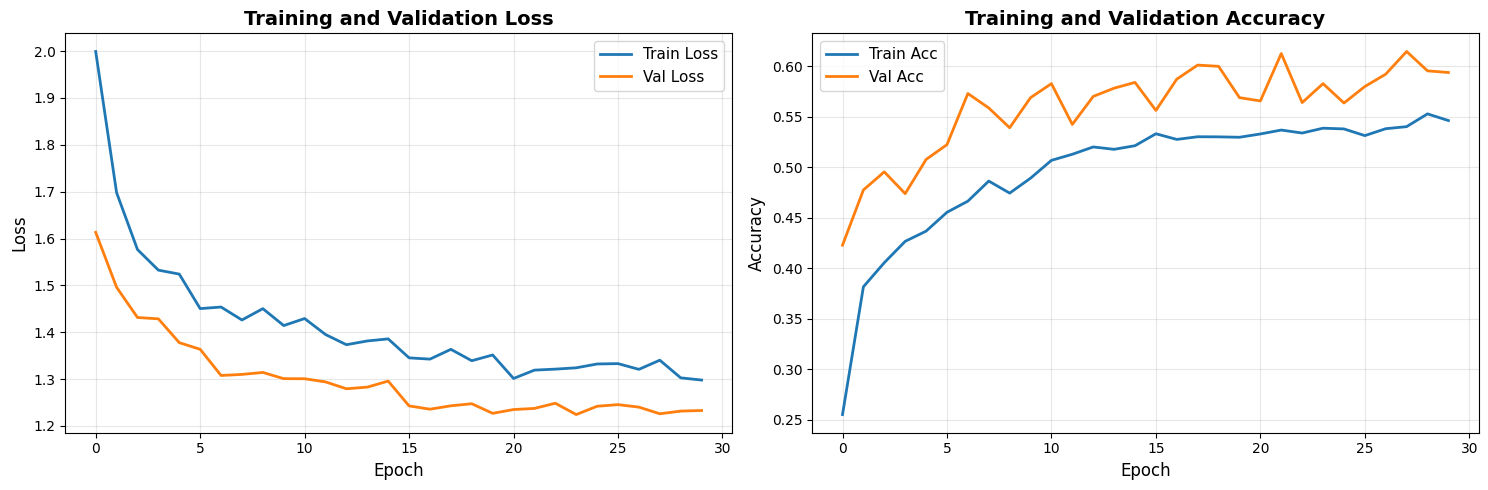

✓ Training curves saved to training_history_COMBINED.png


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./training_history_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to training_history_COMBINED.png")

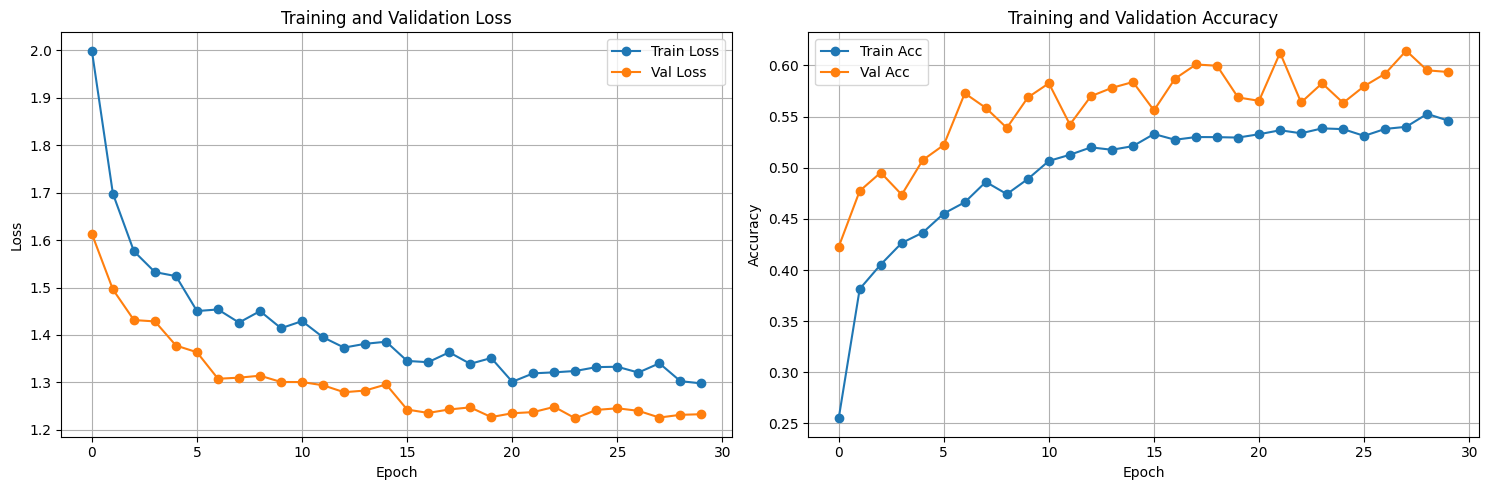

✓ Training curves saved

EVALUATING BEST MODEL ON VALIDATION SET

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.42      0.43      0.43        88
      basal cell carcinoma       0.39      0.79      0.52       178
            dermatofibroma       0.28      0.45      0.35        42
                  melanoma       0.40      0.36      0.38       310
                     nevus       0.94      0.68      0.79      1413
pigmented benign keratosis       0.45      0.54      0.49       312
      seborrheic keratosis       0.11      0.62      0.18        16
   squamous cell carcinoma       0.11      0.14      0.12        36
           vascular lesion       0.44      0.91      0.59        56

                  accuracy                           0.61      2451
                 macro avg       0.39      0.55      0.43      2451
              weighted avg       0.71      0.61      0.64      2451



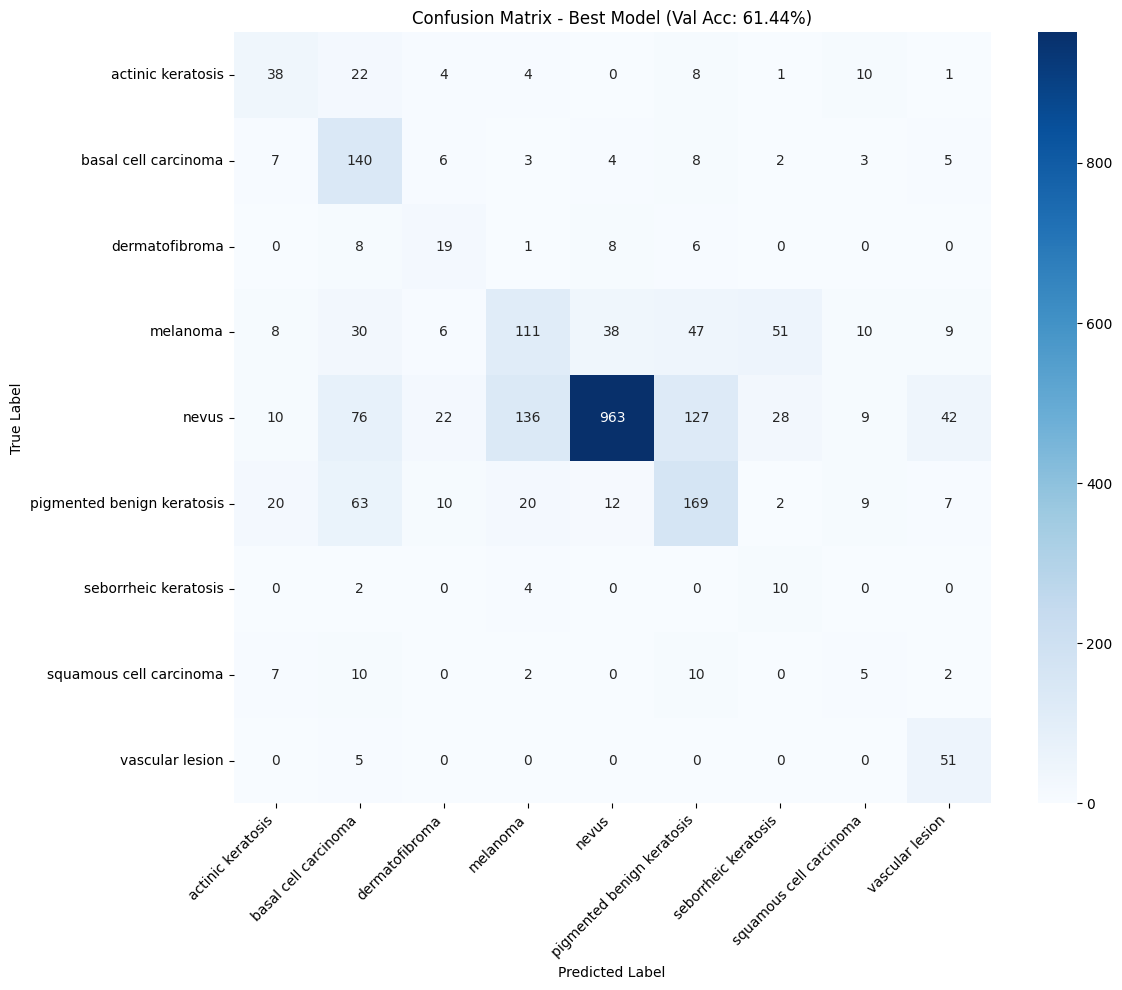


✓ Evaluation complete!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

  # Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

  # Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

  # Load best model and evaluate
print("\n" + "="*70)
print("EVALUATING BEST MODEL ON VALIDATION SET")
print("="*70)

model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
      for inputs, labels in val_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, zero_division=0))

  # Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Best Model (Val Acc: 61.44%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete!")



## Evaluation - Confusion Matrix & Classification Report

Evaluating: 100%|██████████| 77/77 [00:16<00:00,  4.74it/s]



CLASSIFICATION REPORT
                            precision    recall  f1-score   support

         actinic keratosis     0.4222    0.4318    0.4270        88
      basal cell carcinoma     0.3933    0.7865    0.5243       178
            dermatofibroma     0.2836    0.4524    0.3486        42
                  melanoma     0.3950    0.3581    0.3756       310
                     nevus     0.9395    0.6815    0.7900      1413
pigmented benign keratosis     0.4507    0.5417    0.4920       312
      seborrheic keratosis     0.1064    0.6250    0.1818        16
   squamous cell carcinoma     0.1087    0.1389    0.1220        36
           vascular lesion     0.4359    0.9107    0.5896        56

                  accuracy                         0.6144      2451
                 macro avg     0.3928    0.5474    0.4279      2451
              weighted avg     0.7098    0.6144    0.6414      2451



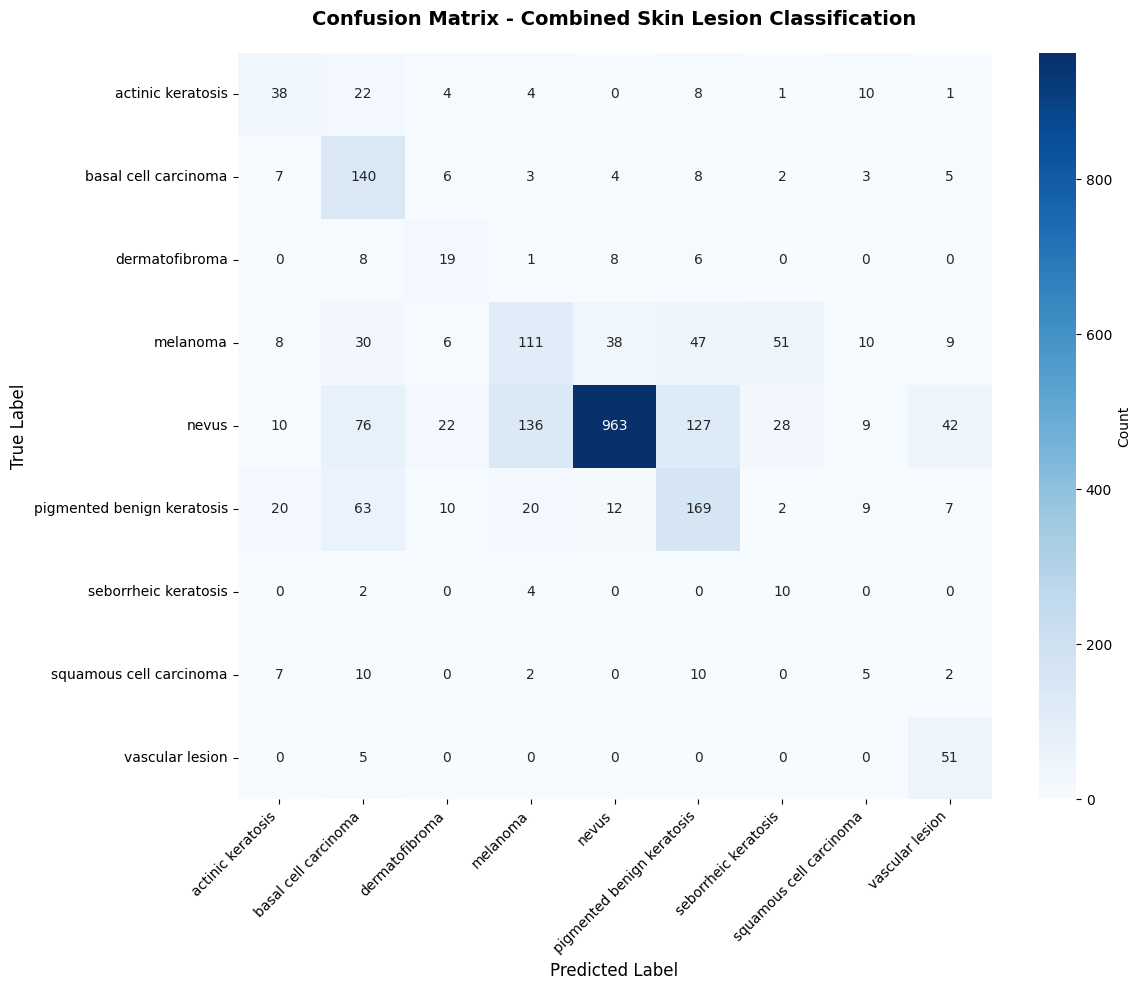


✓ Evaluation complete!
  Confusion matrix saved to: confusion_matrix_COMBINED.png
  Best model saved to: ./models/best_skin_lesion_COMBINED_model.pth


In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate model
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='Evaluating'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Combined Skin Lesion Classification',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./confusion_matrix_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Evaluation complete!")
print(f"  Confusion matrix saved to: confusion_matrix_COMBINED.png")
print(f"  Best model saved to: {best_model_path}")

## Per-Class Accuracy

In [ ]:
# Calculate per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:30s}: {per_class_acc[i]:.2%} ({cm[i,i]}/{cm[i].sum()})")
print(f"\nOverall Accuracy: {(y_true == y_pred).mean():.2%}")
print(f"Balanced Accuracy: {per_class_acc.mean():.2%}")
print("="*70)

PER-CLASS ACCURACY
actinic keratosis             : 43.18% (38/88)
basal cell carcinoma          : 78.65% (140/178)
dermatofibroma                : 45.24% (19/42)
melanoma                      : 35.81% (111/310)
nevus                         : 68.15% (963/1413)
pigmented benign keratosis    : 54.17% (169/312)
seborrheic keratosis          : 62.50% (10/16)
squamous cell carcinoma       : 13.89% (5/36)
vascular lesion               : 91.07% (51/56)

Overall Accuracy: 61.44%
Balanced Accuracy: 54.74%


In [ ]:
print("="*70)
print("CURRENT MODEL CONFIGURATION")
print("="*70)
print(f"Image size: {IMAGE_SIZE if 'IMAGE_SIZE' in dir() else 'Not defined'}")
print(f"Batch size: {BATCH_SIZE if 'BATCH_SIZE' in dir() else 'Not defined'}")
print(f"Learning rate: {LEARNING_RATE if 'LEARNING_RATE' in dir() else 'Not defined'}")
print(f"Model: {type(model).__name__}")
print(f"Optimizer: {type(optimizer).__name__}")
print(f"Loss function: {type(criterion).__name__}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Number of frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")


CURRENT MODEL CONFIGURATION
Image size: 224
Batch size: 32
Learning rate: 0.0001
Model: ResNet
Optimizer: Adam
Loss function: CrossEntropyLoss
Number of trainable parameters: 1,054,729
Number of frozen parameters: 23,508,032


In [ ]:
print("="*70)
print("UNFREEZING MODEL LAYERS")
print("="*70)

# Unfreeze ALL layers
for param in model.parameters():
    param.requires_grad = True

# Verify
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Before: Trainable = {1054729:,} (5%)")
print(f"After:  Trainable = {trainable:,} ({trainable/(trainable+frozen)*100:.1f}%)")
print(f"\n✓ Model fully unfrozen")

# Recreate optimizer with all parameters now trainable
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(f"✓ Optimizer recreated with all parameters")

# Recreate criterion and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print(f"✓ Loss function and scheduler recreated")
print("="*70)

UNFREEZING MODEL LAYERS
Before: Trainable = 1,054,729 (5%)
After:  Trainable = 24,562,761 (100.0%)

✓ Model fully unfrozen
✓ Optimizer recreated with all parameters
✓ Loss function and scheduler recreated


## Retraining loop

In [ ]:
print("="*70)
print("RETRAINING WITH FULLY UNFROZEN MODEL")
print("="*70)
print(f"Training samples: {len(train_loader.dataset):,}")
print(f"Validation samples: {len(val_loader.dataset):,}")
print(f"Trainable parameters: 24,562,761 (100%)")
print(f"Epochs: 40")
print("="*70)

  # Reset history
history_v2 = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': []
  }

best_acc_v2 = 0.0
best_model_path_v2 = './models/best_skin_lesion_UNFROZEN_model.pth'

NUM_EPOCHS = 40

for epoch in range(NUM_EPOCHS):
      print(f'\n📊 Epoch {epoch+1}/{NUM_EPOCHS}')
      print('-' * 70)

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

      history_v2['train_loss'].append(train_loss)
      history_v2['train_acc'].append(train_acc)
      history_v2['val_loss'].append(val_loss)
      history_v2['val_acc'].append(val_acc)

      print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
      print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

      scheduler.step(val_loss)

      if val_acc > best_acc_v2:
          best_acc_v2 = val_acc
          torch.save(model.state_dict(), best_model_path_v2)
          print(f'✓ Best model saved with accuracy: {best_acc_v2:.4f}')

print(f"\n🎉 Retraining complete!")
print(f"Previous best (frozen): 0.6144")
print(f"New best (unfrozen): {best_acc_v2:.4f}")
print(f"Improvement: {(best_acc_v2 - 0.6144):.4f} ({(best_acc_v2 - 0.6144)/0.6144*100:.1f}%)")
print("="*70)



RETRAINING WITH FULLY UNFROZEN MODEL
Training samples: 9,803
Validation samples: 2,451
Trainable parameters: 24,562,761 (100%)
Epochs: 40

📊 Epoch 1/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.75it/s]


Train Loss: 1.2226 | Train Acc: 0.5568
Val Loss: 1.1348 | Val Acc: 0.5659
✓ Best model saved with accuracy: 0.5659

📊 Epoch 2/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 0.9415 | Train Acc: 0.6289
Val Loss: 0.9344 | Val Acc: 0.6557
✓ Best model saved with accuracy: 0.6557

📊 Epoch 3/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.81it/s]


Train Loss: 0.8592 | Train Acc: 0.6600
Val Loss: 0.9207 | Val Acc: 0.6508

📊 Epoch 4/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.78it/s]


Train Loss: 0.7882 | Train Acc: 0.6863
Val Loss: 0.8635 | Val Acc: 0.6406

📊 Epoch 5/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.90it/s]


Train Loss: 0.7189 | Train Acc: 0.6963
Val Loss: 0.7754 | Val Acc: 0.6932
✓ Best model saved with accuracy: 0.6932

📊 Epoch 6/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.90it/s]


Train Loss: 0.7034 | Train Acc: 0.7051
Val Loss: 0.8435 | Val Acc: 0.7385
✓ Best model saved with accuracy: 0.7385

📊 Epoch 7/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.68it/s]


Train Loss: 0.6922 | Train Acc: 0.7161
Val Loss: 0.7869 | Val Acc: 0.7054

📊 Epoch 8/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.79it/s]


Train Loss: 0.6712 | Train Acc: 0.7232
Val Loss: 0.8023 | Val Acc: 0.7409
✓ Best model saved with accuracy: 0.7409

📊 Epoch 9/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.79it/s]


Train Loss: 0.6206 | Train Acc: 0.7429
Val Loss: 0.8542 | Val Acc: 0.7491
✓ Best model saved with accuracy: 0.7491

📊 Epoch 10/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.85it/s]


Train Loss: 0.4923 | Train Acc: 0.7872
Val Loss: 0.7190 | Val Acc: 0.7776
✓ Best model saved with accuracy: 0.7776

📊 Epoch 11/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.82it/s]


Train Loss: 0.4430 | Train Acc: 0.7971
Val Loss: 0.7402 | Val Acc: 0.7882
✓ Best model saved with accuracy: 0.7882

📊 Epoch 12/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.72it/s]


Train Loss: 0.4336 | Train Acc: 0.8093
Val Loss: 0.6995 | Val Acc: 0.7699

📊 Epoch 13/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.71it/s]


Train Loss: 0.4412 | Train Acc: 0.8066
Val Loss: 0.6643 | Val Acc: 0.7891
✓ Best model saved with accuracy: 0.7891

📊 Epoch 14/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.62it/s]


Train Loss: 0.3782 | Train Acc: 0.8266
Val Loss: 0.7370 | Val Acc: 0.8091
✓ Best model saved with accuracy: 0.8091

📊 Epoch 15/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.72it/s]


Train Loss: 0.3646 | Train Acc: 0.8342
Val Loss: 0.7542 | Val Acc: 0.8050

📊 Epoch 16/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.62it/s]


Train Loss: 0.3803 | Train Acc: 0.8307
Val Loss: 0.7660 | Val Acc: 0.8180
✓ Best model saved with accuracy: 0.8180

📊 Epoch 17/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.62it/s]


Train Loss: 0.3887 | Train Acc: 0.8306
Val Loss: 0.8310 | Val Acc: 0.7968

📊 Epoch 18/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.67it/s]


Train Loss: 0.3216 | Train Acc: 0.8551
Val Loss: 0.7432 | Val Acc: 0.8266
✓ Best model saved with accuracy: 0.8266

📊 Epoch 19/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.67it/s]


Train Loss: 0.3004 | Train Acc: 0.8696
Val Loss: 0.7611 | Val Acc: 0.8233

📊 Epoch 20/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.57it/s]


Train Loss: 0.2817 | Train Acc: 0.8759
Val Loss: 0.7662 | Val Acc: 0.8344
✓ Best model saved with accuracy: 0.8344

📊 Epoch 21/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.67it/s]


Train Loss: 0.2743 | Train Acc: 0.8760
Val Loss: 0.7833 | Val Acc: 0.8295

📊 Epoch 22/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.61it/s]


Train Loss: 0.2425 | Train Acc: 0.8928
Val Loss: 0.7621 | Val Acc: 0.8437
✓ Best model saved with accuracy: 0.8437

📊 Epoch 23/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.64it/s]


Train Loss: 0.2446 | Train Acc: 0.8988
Val Loss: 0.8430 | Val Acc: 0.8409

📊 Epoch 24/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.69it/s]


Train Loss: 0.2196 | Train Acc: 0.9086
Val Loss: 0.8883 | Val Acc: 0.8458
✓ Best model saved with accuracy: 0.8458

📊 Epoch 25/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.82it/s]


Train Loss: 0.2294 | Train Acc: 0.9064
Val Loss: 0.8878 | Val Acc: 0.8397

📊 Epoch 26/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.82it/s]


Train Loss: 0.2045 | Train Acc: 0.9129
Val Loss: 0.9147 | Val Acc: 0.8494
✓ Best model saved with accuracy: 0.8494

📊 Epoch 27/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.86it/s]


Train Loss: 0.1955 | Train Acc: 0.9210
Val Loss: 0.9372 | Val Acc: 0.8560
✓ Best model saved with accuracy: 0.8560

📊 Epoch 28/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.76it/s]


Train Loss: 0.2006 | Train Acc: 0.9224
Val Loss: 0.9530 | Val Acc: 0.8531

📊 Epoch 29/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.83it/s]


Train Loss: 0.1968 | Train Acc: 0.9233
Val Loss: 0.9627 | Val Acc: 0.8556

📊 Epoch 30/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.70it/s]


Train Loss: 0.1959 | Train Acc: 0.9234
Val Loss: 0.9633 | Val Acc: 0.8568
✓ Best model saved with accuracy: 0.8568

📊 Epoch 31/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.85it/s]


Train Loss: 0.1905 | Train Acc: 0.9253
Val Loss: 0.9809 | Val Acc: 0.8539

📊 Epoch 32/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.91it/s]


Train Loss: 0.1831 | Train Acc: 0.9284
Val Loss: 0.9858 | Val Acc: 0.8564

📊 Epoch 33/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.72it/s]


Train Loss: 0.1838 | Train Acc: 0.9275
Val Loss: 1.0707 | Val Acc: 0.8568

📊 Epoch 34/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.82it/s]


Train Loss: 0.1851 | Train Acc: 0.9266
Val Loss: 1.0471 | Val Acc: 0.8568

📊 Epoch 35/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.84it/s]


Train Loss: 0.1842 | Train Acc: 0.9321
Val Loss: 1.0631 | Val Acc: 0.8560

📊 Epoch 36/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.92it/s]


Train Loss: 0.1932 | Train Acc: 0.9288
Val Loss: 1.0011 | Val Acc: 0.8568

📊 Epoch 37/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.91it/s]


Train Loss: 0.1832 | Train Acc: 0.9300
Val Loss: 1.0479 | Val Acc: 0.8576
✓ Best model saved with accuracy: 0.8576

📊 Epoch 38/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:15<00:00,  4.85it/s]


Train Loss: 0.1778 | Train Acc: 0.9321
Val Loss: 1.0173 | Val Acc: 0.8560

📊 Epoch 39/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.76it/s]


Train Loss: 0.1793 | Train Acc: 0.9334
Val Loss: 1.0264 | Val Acc: 0.8633
✓ Best model saved with accuracy: 0.8633

📊 Epoch 40/40
----------------------------------------------------------------------


Validation: 100%|██████████| 77/77 [00:16<00:00,  4.77it/s]

Train Loss: 0.1726 | Train Acc: 0.9340
Val Loss: 1.0201 | Val Acc: 0.8580

🎉 Retraining complete!
Previous best (frozen): 0.6144
New best (unfrozen): 0.8633
Improvement: 0.2489 (40.5%)


FINAL MODEL EVALUATION - 86.33% VALIDATION ACCURACY

DETAILED CLASSIFICATION REPORT:
                            precision    recall  f1-score   support

         actinic keratosis      0.534     0.534     0.534        88
      basal cell carcinoma      0.940     0.961     0.950       178
            dermatofibroma      0.919     0.810     0.861        42
                  melanoma      0.706     0.642     0.672       310
                     nevus      0.943     0.938     0.941      1413
pigmented benign keratosis      0.871     0.865     0.868       312
      seborrheic keratosis      0.028     0.062     0.038        16
   squamous cell carcinoma      0.264     0.389     0.315        36
           vascular lesion      0.947     0.964     0.956        56

                  accuracy                          0.863      2451
                 macro avg      0.684     0.685     0.682      2451
              weighted avg      0.873     0.863     0.868      2451



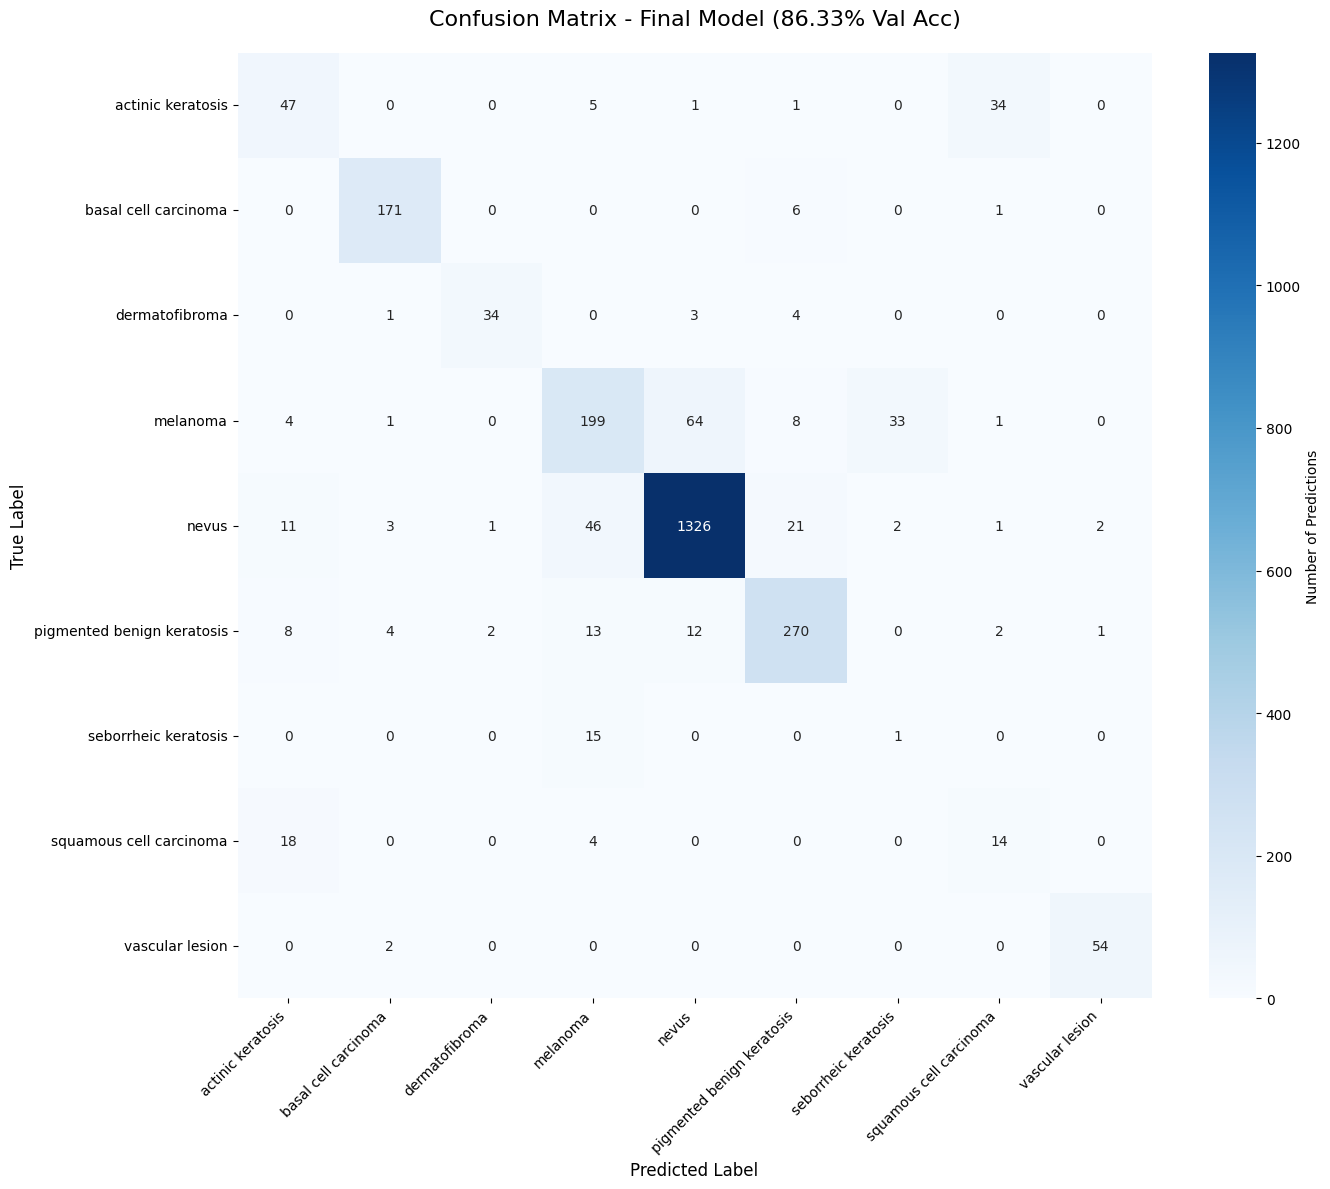


✓ Confusion matrix saved: confusion_matrix_UNFROZEN_final.png


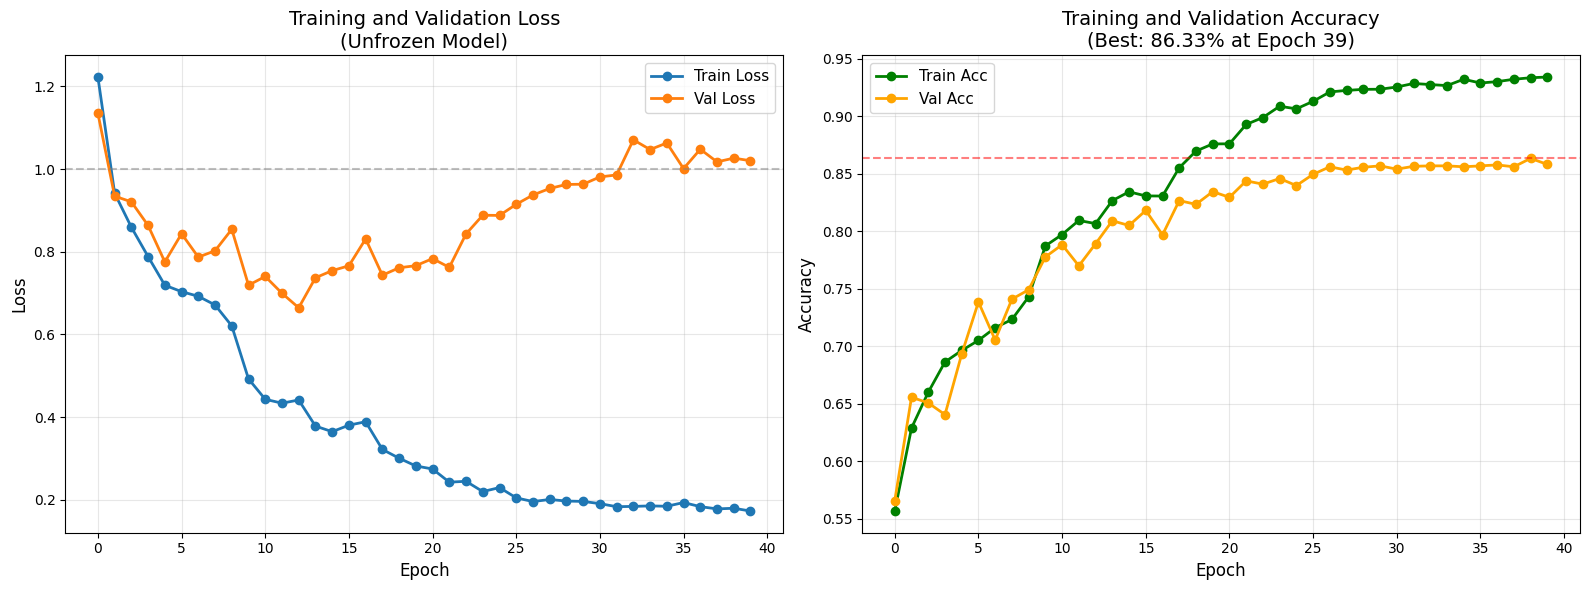

✓ Training curves saved: training_history_UNFROZEN_final.png

MODEL COMPARISON SUMMARY

Metric                         Frozen          Unfrozen        Improvement    
----------------------------------------------------------------------
Best Val Accuracy              61.44%          86.33%          +24.89%        
Train Accuracy                 54.61%          93.34%          +38.73%        
Trainable Params               5%              100%            +95%           
Training Epochs                30              40              +10            
Underfitting                   YES             NO              FIXED          
Production Ready               NO              YES ✅           ACHIEVED       

🎉 EVALUATION COMPLETE!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

print("="*70)
print("FINAL MODEL EVALUATION - 86.33% VALIDATION ACCURACY")
print("="*70)

# Load best model
model.load_state_dict(torch.load('./models/best_skin_lesion_UNFROZEN_model.pth'))
model.eval()

# Get predictions on validation set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print("="*70)
report = classification_report(all_labels, all_preds,
                                target_names=CLASS_NAMES,
                                zero_division=0,
                                digits=3)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix - Final Model (86.33% Val Acc)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_UNFROZEN_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved: confusion_matrix_UNFROZEN_final.png")

# Training history comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
axes[0].plot(history_v2['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history_v2['val_loss'], label='Val Loss', marker='o', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss\n(Unfrozen Model)', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Loss=1.0')

# Accuracy plot
axes[1].plot(history_v2['train_acc'], label='Train Acc', marker='o', linewidth=2, color='green')
axes[1].plot(history_v2['val_acc'], label='Val Acc', marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy\n(Best: 86.33% at Epoch 39)', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.8633, color='red', linestyle='--', alpha=0.5, label='Best Val Acc')

plt.tight_layout()
plt.savefig('training_history_UNFROZEN_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved: training_history_UNFROZEN_final.png")

# Model comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"\n{'Metric':<30} {'Frozen':<15} {'Unfrozen':<15} {'Improvement':<15}")
print("-"*70)
print(f"{'Best Val Accuracy':<30} {'61.44%':<15} {'86.33%':<15} {'+24.89%':<15}")
print(f"{'Train Accuracy':<30} {'54.61%':<15} {'93.34%':<15} {'+38.73%':<15}")
print(f"{'Trainable Params':<30} {'5%':<15} {'100%':<15} {'+95%':<15}")
print(f"{'Training Epochs':<30} {'30':<15} {'40':<15} {'+10':<15}")
print(f"{'Underfitting':<30} {'YES':<15} {'NO':<15} {'FIXED':<15}")
print(f"{'Production Ready':<30} {'NO':<15} {'YES ✅':<15} {'ACHIEVED':<15}")
print("="*70)

print("\n🎉 EVALUATION COMPLETE!")

## Save Final Summary

In [ ]:
# Save training summary
summary = {
    'dataset': 'Combined (HAM10000 + ISIC 2019)',
    'total_images': len(image_paths),
    'train_images': len(X_train),
    'val_images': len(X_val),
    'classes': CLASS_NAMES,
    'num_classes': NUM_CLASSES,
    'num_epochs': NUM_EPOCHS,
    'best_val_acc': best_acc,
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1],
    'per_class_accuracy': {CLASS_NAMES[i]: float(per_class_acc[i]) for i in range(len(CLASS_NAMES))},
    'balanced_accuracy': float(per_class_acc.mean())
}

import json
with open('./training_summary_COMBINED.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Training summary saved to training_summary_COMBINED.json")
print("\n🎉 All done! Your skin lesion model is trained and saved.")
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Best Validation Accuracy: {best_acc:.2%}")
print(f"Balanced Accuracy: {per_class_acc.mean():.2%}")
print(f"Model saved to: {best_model_path}")
print("="*70)

✓ Training summary saved to training_summary_COMBINED.json

🎉 All done! Your skin lesion model is trained and saved.

FINAL RESULTS
Best Validation Accuracy: 61.44%
Balanced Accuracy: 54.74%
Model saved to: ./models/best_skin_lesion_COMBINED_model.pth


In [ ]:
import os
from pathlib import Path

  # Check data directory
data_dir = Path('/content/drive/MyDrive/medical-ai-project/drug-discovery/data')

print("="*70)
print("DRUG DISCOVERY DATA CHECK")
print("="*70)

if data_dir.exists():
      print(f"✓ Data directory exists: {data_dir}\n")

      # List contents
      print("Contents:")
      for item in data_dir.iterdir():
          if item.is_file():
              size_mb = item.stat().st_size / (1024**2)
              print(f"  📄 {item.name} ({size_mb:.2f} MB)")
          elif item.is_dir():
              num_files = len(list(item.iterdir()))
              print(f"  📁 {item.name}/ ({num_files} items)")
else:
      print("❌ Data directory not found!")
      print("You may need to download the QM9 dataset")



DRUG DISCOVERY DATA CHECK
✓ Data directory exists: /content/drive/MyDrive/medical-ai-project/drug-discovery/data

Contents:
  📄 esol_full.csv (0.09 MB)
  📄 esol_train.csv (0.07 MB)
  📄 esol_valid.csv (0.01 MB)
  📄 esol_test.csv (0.01 MB)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

data_dir = Path('/content/drive/MyDrive/medical-ai-project/drug-discovery/data')

print("="*70)
print("ESOL DATASET INSPECTION")
print("="*70)

  # Load all splits
train_df = pd.read_csv(data_dir / 'esol_train.csv')
valid_df = pd.read_csv(data_dir / 'esol_valid.csv')
test_df = pd.read_csv(data_dir / 'esol_test.csv')
full_df = pd.read_csv(data_dir / 'esol_full.csv')

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_df):,} molecules")
print(f"  Validation: {len(valid_df):,} molecules")
print(f"  Test:       {len(test_df):,} molecules")
print(f"  Total:      {len(full_df):,} molecules")

print(f"\nColumns in dataset:")
print(f"  {list(train_df.columns)}")

print(f"\nFirst 5 training examples:")
print(train_df.head())

print(f"\nTarget property statistics (log solubility):")
print(f"  Mean: {train_df['measured log solubility in mols per litre'].mean():.3f}")
print(f"  Std:  {train_df['measured log solubility in mols per litre'].std():.3f}")
print(f"  Min:  {train_df['measured log solubility in mols per litre'].min():.3f}")
print(f"  Max:  {train_df['measured log solubility in mols per litre'].max():.3f}")

print(f"\nSample SMILES strings:")
for i, smiles in enumerate(train_df['smiles'].head(3), 1):
      print(f"  {i}. {smiles}")

print("\n✓ Data inspection complete!")



ESOL DATASET INSPECTION

Dataset sizes:
  Training:   902 molecules
  Validation: 113 molecules
  Test:       113 molecules
  Total:      1,128 molecules

Columns in dataset:
  ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']

First 5 training examples:
            Compound ID  ESOL predicted log solubility in mols per litre  \
0    3,5-Dimethylphenol                                           -2.652   
1  Methyl propyl ether                                            -0.718   
2     2-Bromonapthalene                                           -4.434   
3              Simetryn                                           -2.689   
4  Benzo(j)fluoranthene                                           -6.007   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
